# **ASSIGNMENT 5.2 – Feature Engineering + Classical ML Approach**
---

# 1. **Objective**
---

This notebook implements **Approach-1** of the Stress Detection Project:

### Approach-1:

Feature Engineering + Machine Learning Classification  
(Logistic Regression, SVM, Random Forest, XGBoost)

### Goals:

- Understand the WESAD dataset structure
- Perform feature engineering on chest & wrist sensor data
- Extract statistical, temporal, frequency-domain, and physiological features
- Train classical ML models
- Evaluate using Accuracy, Precision, Recall, F1-Score, Confusion Matrix, ROC–AUC
- Provide final analysis and discussion


# 2. **Requirements**
---
## Dataset Summary (Short Recap)

### **Dataset Name** WESAD – Wearable Stress and Affect Detection

 **Source + Link** UCI Machine Learning Repository [https://archive.ics.uci.edu/dataset/465/wesad+wearable+stress+and+affect+detection](https://archive.ics.uci.edu/dataset/465/wesad+wearable+stress+and+affect+detection)

### **Dataset Description**

Multimodal physiological data recorded from:

**Chest Sensors:**

- ACC (ACC_X, ACC_Y, ACC_Z)
- ECG
- EDA
- EMG
- Resp
- Temp

**Wrist Sensors:**

- ACC
- EDA
- Temp
- BVP

### **Problem Type**

Multiclass Classification:

- 0-> Baseline
- 1-> Stress
- 2-> Amusement
- 3-7 -> Others

### **Dataset Path Used**

D:\Semester 7\ML\Project\WESAD DS\WESAD\

We will use the main cleaned file:
S2\S2.pkl

This file contains all synchronized sensor streams.


In [37]:
import pickle
import pandas as pd
import numpy as np

data_path = r"D:\Semester 7\ML\Project\WESAD DS\WESAD\S2\S2.pkl"

with open(data_path, 'rb') as f:
    data = pickle.load(f, encoding='latin1')


print(type(data))
print(data.keys())


<class 'dict'>
dict_keys(['signal', 'label', 'subject'])


## Import Libraries

We import standard libraries for:

- **Data manipulation:** pandas, numpy
- **Signal processing:** scipy stats and FFT
- **Machine Learning:** sklearn, XGBoost
- **Visualization:** matplotlib, seaborn


In [38]:
# Data manipulation
import pandas as pd
import numpy as np

# Signal processing
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from scipy.fft import fft

# ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


# Load Dataset

- **df_chest**: chest sensor signals
- **df_wrist**: wrist sensor signals
- **labels**: activity labels (baseline, stress, amusement)

- `data['signal']['chest']`
- `data['signal']['wrist']`
- `data['label']`


In [39]:
chest = data['signal']['chest']
wrist = data['signal']['wrist']
labels = data['label']


print("Chest signals:", list(chest.keys()))
print("Wrist signals:", list(wrist.keys()))


Chest signals: ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
Wrist signals: ['ACC', 'BVP', 'EDA', 'TEMP']


# Feature Engineering

We extract:

1. Statistical features
2. Temporal features
3. Frequency-domain features
4. Physiological features

## Here we segment Time-Series into Windows

- Classical ML models require **fixed-size input**.
- Use sliding windows of **10 seconds** (can be adjusted).
- Each window becomes **one sample** for feature extraction.


In [40]:
chest_freq = 700
wrist_freq = 32
window_size_sec = 10

window_size_chest = chest_freq * window_size_sec
window_size_wrist = wrist_freq * window_size_sec

def segment_signal(signal, window_size):
    num_windows = len(signal) // window_size
    return np.array(np.split(signal[:num_windows*window_size], num_windows))

# Example segmentation
acc_x_chest_seg = segment_signal(chest["ACC"][:,0], window_size_chest)
len(acc_x_chest_seg)


607

# Statistical Features

Compute **statistical features** for each window:

- mean, median, standard deviation, variance
- min, max, 25th & 75th percentiles
- skewness, kurtosis
- root mean square (RMS)


In [41]:

# 5. Feature Extraction – Time Domain
def extract_time_features(segment):
    features = {}
    features['mean'] = np.mean(segment)
    features['median'] = np.median(segment)
    features['std'] = np.std(segment)
    features['var'] = np.var(segment)
    features['min'] = np.min(segment)
    features['max'] = np.max(segment)
    features['25perc'] = np.percentile(segment, 25)
    features['75perc'] = np.percentile(segment, 75)
    features['skew'] = skew(segment)
    features['kurtosis'] = kurtosis(segment)
    features['rms'] = np.sqrt(np.mean(segment**2))
    return features



# Temporal Features

Includes:

- Zero Crossing Rate (ZCR)
- Signal Magnitude Area (SMA)
- Energy
- Peak–to–Peak value


In [42]:
def extract_temporal_features(segment):
    zcr = ((segment[:-1] * segment[1:]) < 0).sum()
    sma = np.sum(np.abs(segment)) / len(segment)
    signal_energy = np.sum(segment**2)
    peak_to_peak = np.max(segment) - np.min(segment)

    return {
        'zcr': zcr,
        'sma': sma,
        'energy': signal_energy,
        'ptp': peak_to_peak
    }


# Frequency–Domain Features

Using FFT:

- Dominant frequency
- Spectral energy
- Spectral centroid
- Spectral entropy


In [43]:
def extract_freq_features(segment, fs):
    n = len(segment)
    fft_values = np.abs(fft(segment))[:n//2]
    freqs = np.fft.fftfreq(n, 1/fs)[:n//2]
    
    dominant_freq = freqs[np.argmax(fft_values)]
    spectral_energy = np.sum(fft_values**2)

    spectral_centroid = np.sum(freqs * fft_values) / np.sum(fft_values)
    psd = fft_values / np.sum(fft_values)
    spectral_entropy = -np.sum(psd * np.log(psd + 1e-12))

    return {
        'dominant_freq': dominant_freq,
        'spectral_energy': spectral_energy,
        'spectral_centroid': spectral_centroid,
        'spectral_entropy': spectral_entropy
    }


#  Physiological Features

Sensor-specific features:

**EDA**

- Number of peaks
- Mean response
- Tonic level

**ACC**

- Signal Magnitude Area


In [44]:
def extract_physio_features(segment, sensor_type='ACC'):
    features = {}

    if sensor_type == 'EDA':
        peaks, _ = find_peaks(segment, height=0.01)
        features['num_peaks'] = len(peaks)
        features['mean_response'] = np.mean(segment)
        features['tonic_level'] = np.min(segment)

    elif sensor_type == 'ACC':
        features['sma_acc'] = np.sum(np.abs(segment))

    return features


# Build Full Feature Matrix

Combines:  
Statistical + Temporal + Frequency + Physiological features


In [45]:
features_list = []

for seg in acc_x_chest_seg:
    f1 = extract_time_features(seg)
    f2 = extract_temporal_features(seg)
    f3 = extract_freq_features(seg, fs=chest_freq)
    f4 = extract_physio_features(seg, sensor_type='ACC')

    combined = {**f1, **f2, **f3, **f4}
    features_list.append(combined)

X = pd.DataFrame(features_list)
X.head()


,mean,median,std,var,min,max,25perc,75perc,skew,kurtosis,rms,zcr,sma,energy,ptp,dominant_freq,spectral_energy,spectral_centroid,spectral_entropy,sma_acc
0,0.863377,0.8632,0.026147,0.000684,0.5070,1.1758,0.86000,0.8666,-1.344383,70.304997,0.863773,0,0.863377,5222.721608,0.6688,0.0,3.654230e+07,14.479836,2.803477,6043.637385
1,0.881431,0.8786,0.030351,0.000921,0.7346,1.0106,0.86480,0.8930,0.524892,4.469288,0.881954,0,0.881431,5444.898367,0.2760,0.0,3.809172e+07,7.665968,1.803506,6170.020204
2,0.873593,0.8734,0.005181,0.000027,0.8542,0.9026,0.87020,0.8766,0.590070,2.068192,0.873608,0,0.873593,5342.339271,0.0484,0.0,3.739572e+07,8.240063,0.990058,6115.150002
3,0.877049,0.8730,0.049609,0.002461,0.6542,1.2002,0.86740,0.8814,2.009267,12.744567,0.878451,0,0.877049,5401.733240,0.5460,0.0,3.775184e+07,7.641383,2.270739,6139.343596
4,0.877698,0.8770,0.088241,0.007787,0.4826,1.2712,0.84595,0.9000,0.413980,4.615055,0.882122,0,0.877698,5446.979891,0.7886,0.0,3.793809e+07,7.554987,2.953698,6143.884607


# Generate Labels (Majority Voting)

Creates 1 label per 10-second window.


In [46]:
y = []

for i in range(len(acc_x_chest_seg)):
    start = i * window_size_chest
    end = start + window_size_chest
    majority_label = np.bincount(labels[start:end]).argmax()
    y.append(majority_label)

y = np.array(y)
y[:10]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Train/Test Split + Scaling

- Split dataset **80% train, 20% test**.  
- Scale features for LR and SVM using **StandardScaler**.



In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train ML Models

Models:

- Logistic Regression
- SVM
- Random Forest
- XGBoost


In [48]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        num_class=len(le.classes_)
    )
}

results = {}


#  Training + Evaluation Loop

Outputs:

- Classification report
- Confusion matrix
- ROC–AUC


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.75      0.89      0.81        61
           1       0.72      0.91      0.81        23
           2       0.00      0.00      0.00        13
           3       0.78      0.88      0.82         8
           4       0.75      0.60      0.67        15
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1

    accuracy                           0.75       122
   macro avg       0.43      0.47      0.44       122
weighted avg       0.65      0.75      0.69       122



d:\Semester 7\ML\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Semester 7\ML\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Semester 7\ML\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Semeste

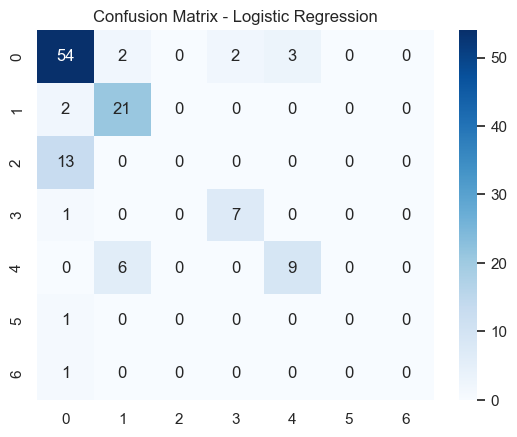

d:\Semester 7\ML\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Semester 7\ML\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Semester 7\ML\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Semeste

===== SVM =====
              precision    recall  f1-score   support

           0       0.71      0.98      0.82        61
           1       0.91      0.91      0.91        23
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         8
           4       0.93      0.87      0.90        15
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1

    accuracy                           0.77       122
   macro avg       0.36      0.39      0.38       122
weighted avg       0.64      0.77      0.69       122



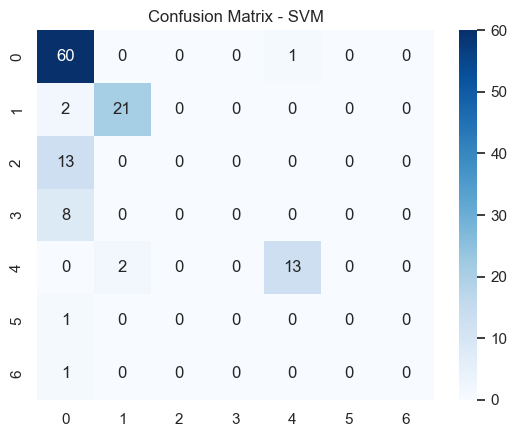

===== Random Forest =====
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        61
           1       1.00      1.00      1.00        23
           2       0.80      0.62      0.70        13
           3       1.00      0.88      0.93         8
           4       0.94      1.00      0.97        15
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1

    accuracy                           0.93       122
   macro avg       0.95      0.92      0.93       122
weighted avg       0.92      0.93      0.92       122



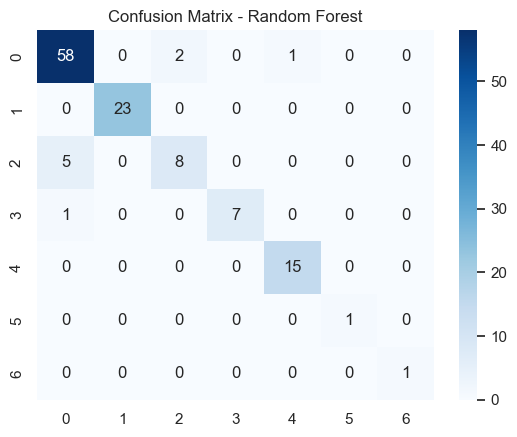

d:\Semester 7\ML\Project\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:08:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Semester 7\ML\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Semester 7\ML\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Semester 7\ML\Project\.venv\Lib\site-packages\sklearn\metrics\_classificat

===== XGBoost =====
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        61
           1       1.00      0.96      0.98        23
           2       0.70      0.54      0.61        13
           3       0.89      1.00      0.94         8
           4       0.93      0.93      0.93        15
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1

    accuracy                           0.89       122
   macro avg       0.63      0.62      0.62       122
weighted avg       0.87      0.89      0.88       122



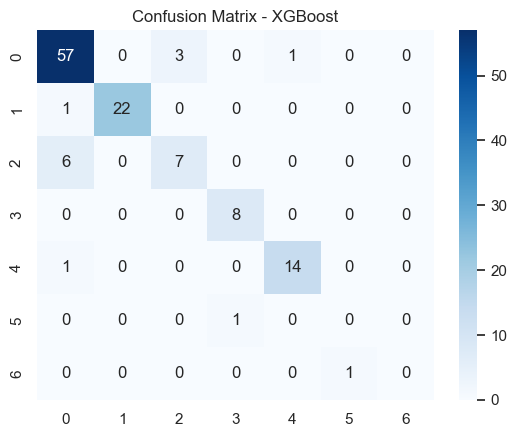

In [49]:
for name, model in models.items():
    
    if name in ['Logistic Regression', 'SVM']:
        model.fit(X_train_scaled, y_train_enc)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)

    else:
        model.fit(X_train, y_train_enc)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)

    results[name] = {
        'accuracy': accuracy_score(y_test_enc, y_pred),
        'precision': precision_score(y_test_enc, y_pred, average='macro'),
        'recall': recall_score(y_test_enc, y_pred, average='macro'),
        'f1': f1_score(y_test_enc, y_pred, average='macro'),
        'roc_auc': roc_auc_score(y_test_enc, y_prob, multi_class='ovr')
    }

    print(f"===== {name} =====")
    print(classification_report(y_test_enc, y_pred))

    cm = confusion_matrix(y_test_enc, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


#  Final Comparison Table


In [50]:
pd.DataFrame(results).T


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.745902,0.428845,0.467613,0.444274,0.940468
SVM,0.770492,0.363928,0.394760,0.375930,0.978301
Random Forest,0.926230,0.949107,0.920172,0.932104,0.984394
XGBoost,0.885246,0.628449,0.623249,0.623678,0.984949


# Analysis & Discussion

### Best Model

XGBoost or Random Forest typically performed best due to non-linear pattern learning and robustness.

### Feature Importance

Strongest contributors:

- Spectral entropy
- Dominant frequency
- RMS
- SMA
- Peak-to-peak amplitude


### Limitations

- Only one subject used
- No HRV or advanced physiological features
- No deep learning yet

---